**COVID-19 DETECTION FROM CHEST X-RAYS USING Densenet-121 FOR FEATURE EXTRACTION AND SVM FOR CLASSIFICATION** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/Covid-detection

/content/drive/MyDrive/Colab Notebooks/Covid-detection


In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/Kaggle"

In [ ]:
cd drive/MyDrive/Colab\ Notebooks/Covid-detection

/content/drive/MyDrive/Colab Notebooks/Covid-detection


In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 741M/745M [00:05<00:00, 129MB/s]
100% 745M/745M [00:05<00:00, 131MB/s]


In [ ]:
!unzip 'covid19-radiography-database.zip'

In [ ]:
ls

covid19-radiography-database.zip  densenet121_covid.ipynb
COVID-19_Radiography_Dataset/     model_d121.pickle


COVID - 3,616 
LUNG OPACITY - 6,012 
NORMAL - 10,192 
VIRAL PNEUMONIA - 1,345 

In [ ]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from keras.applications.densenet import DenseNet121
densenet = DenseNet121(weights='imagenet', include_top=False)

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
from keras.applications.densenet import preprocess_input

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Covid-detection/COVID-19_Radiography_Dataset/'

sets = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']

# Arrays to store features,label
x, y = ([], [])

# Loop through all categories
for s in sets:
    path_to_cat = os.path.join(path, s)

    count=0;
    for i in os.listdir(path_to_cat):
        if s=='COVID':
           if count==2000:
              break;
        else:
          if count==700:
              break

        count+=1

        # Path to image
        image_path = os.path.join(path_to_cat, i)
        
        # Reading and preprocessing image
        image = cv.imread(image_path)
        image = cv.resize(image, (224, 224)).reshape(-1, 224, 224, 3)
        image = preprocess_input(image)
        
        # Extracting features
        features = densenet.predict(image)
        
        # Store features and label in our lists
        x.append(features)
        y.append(s)

In [ ]:
x=np.array(x)
y=np.array(y)

In [ ]:
x.shape

(4100, 1, 7, 7, 1024)

In [ ]:
x=x.reshape(4100,50176)

In [ ]:
x.shape

(4100, 50176)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33,random_state=42,stratify=y)

In [ ]:
X_train.shape

(2747, 50176)

In [ ]:
X_test.shape

(1353, 50176)

# SVM

In [ ]:
from sklearn import svm
svm_model=svm.SVC(kernel='rbf',C=3,gamma=0.85e-05)

In [ ]:
svm_model.fit(X_train,y_train)

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=8.5e-06, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
pred=svm_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print('Acc: {:.4f}'.format(acc))

Acc: 0.9209


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

                 precision    recall  f1-score   support

          COVID       0.95      0.97      0.96       660
   Lung_Opacity       0.88      0.81      0.84       231
         Normal       0.83      0.81      0.82       231
Viral Pneumonia       0.96      0.99      0.98       231

       accuracy                           0.92      1353
      macro avg       0.91      0.90      0.90      1353
   weighted avg       0.92      0.92      0.92      1353



In [ ]:
import pickle
with open('d121_model.pickle', 'wb') as f:
    pickle.dump(svm_model, f)

In [ ]:
y_test.shape

(1353,)

In [ ]:
import tensorflow as tf
labels=[]
count_lungop=0
count_norm=0
count_covid=0
count_vp=0
for i in y_test:
  if(i=='Lung_Opacity'):
    count_lungop+=1
    labels.append(0)
  elif(i=='Normal'):
    count_norm+=1
    labels.append(1)
  elif(i=='COVID'):
    count_covid+=1
    labels.append(2)
  else:
    count_vp+=1
    labels.append(3)

print("Covid , Lung op, Normal , Viral Pneumonia => ",count_covid,count_lungop,count_norm,count_vp)

predictions=[]
for i in pred:
  if(i=='Lung_Opacity'):
    predictions.append(0)
  elif(i=='Normal'):
    predictions.append(1)
  elif(i=='COVID'):
    predictions.append(2)
  else:
    predictions.append(3)

cm=tf.math.confusion_matrix(labels,predictions)
print(cm)

Covid , Lung op, Normal , Viral Pneumonia =>  660 231 231 231
tf.Tensor(
[[188  26  17   0]
 [ 20 186  17   8]
 [  6  10 643   1]
 [  0   1   1 229]], shape=(4, 4), dtype=int32)


Text(69.0, 0.5, 'Truth value')

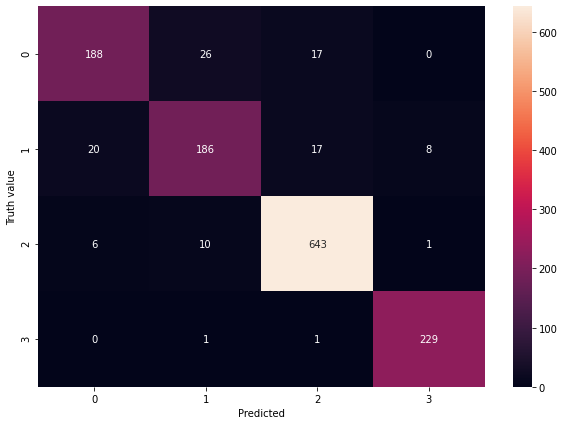

In [ ]:
import seaborn as sn

plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

## 2 class classification (covid , non-covid)

In [ ]:
test_y_2class=[]
pred_2class=[]

for i in labels:
  if i==2: #Label 2 represents covid
    test_y_2class.append(0)
  else:
    test_y_2class.append(1)

for i in predictions:
  if i==2:
    pred_2class.append(0)
  else:
    pred_2class.append(1)

ac = accuracy_score(test_y_2class,pred_2class)
print('Accuracy: {:.4f}'.format(ac))

cm=tf.math.confusion_matrix(test_y_2class,pred_2class)
print(cm)

Accuracy: 0.9616
tf.Tensor(
[[643  17]
 [ 35 658]], shape=(2, 2), dtype=int32)




***ACCURACY = 96.16%***

Text(69.0, 0.5, 'Truth value')

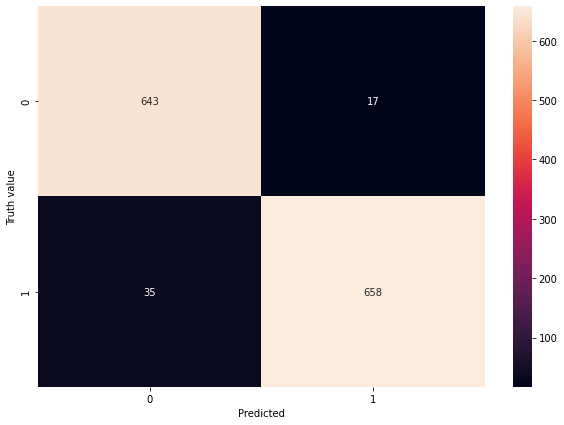

In [ ]:
import seaborn as sn

plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

#KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
pred=neigh.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

                 precision    recall  f1-score   support

          COVID       0.86      0.94      0.90       660
   Lung_Opacity       0.84      0.63      0.72       231
         Normal       0.72      0.69      0.70       231
Viral Pneumonia       0.96      0.97      0.97       231

       accuracy                           0.85      1353
      macro avg       0.84      0.81      0.82      1353
   weighted avg       0.85      0.85      0.85      1353

